In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
from pandas_datareader import data as wb  
import matplotlib.pyplot as plt  
from scipy.stats import norm
%matplotlib inline
# pd.options.plotting.backend = "plotly"


In [2]:
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('renfe_small.txt')
data = data.sample(frac=0.01, random_state=99)
data.head(3)

Running on PyMC3 v3.10.0


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo


In [3]:
import pandas_profiling
pandas_profiling.ProfileReport(data)


In [4]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

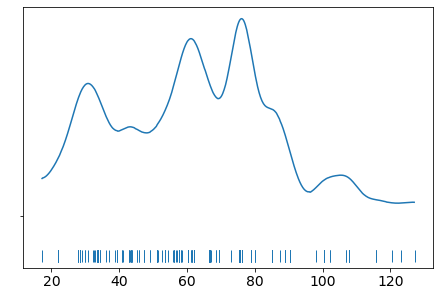

In [5]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);


In [6]:
data.shape

(258, 9)

In [7]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


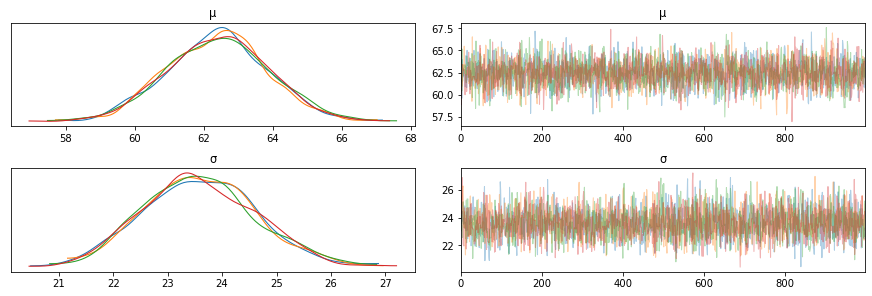

In [8]:
az.plot_trace(trace_g);


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/plots/jointplot.py:144: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")
/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:409: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_cov" failed type inference due to: Untyped global name '_dot': cannot determine Numba type of <class 'arviz.utils.maybe_numba_fn'>

File "../../opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py", line 421:
def _cov(data):
    

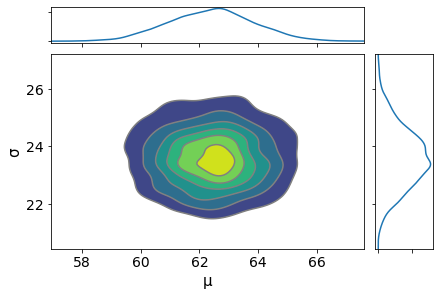

In [9]:
az.plot_joint(trace_g, kind='kde', fill_last=False);


In [10]:
az.summary(trace_g)


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,62.407,1.468,59.599,65.028,0.026,0.018,3277.0,3277.0,3293.0,2702.0,1.0
σ,23.597,1.028,21.795,25.616,0.018,0.013,3311.0,3291.0,3345.0,2787.0,1.0


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


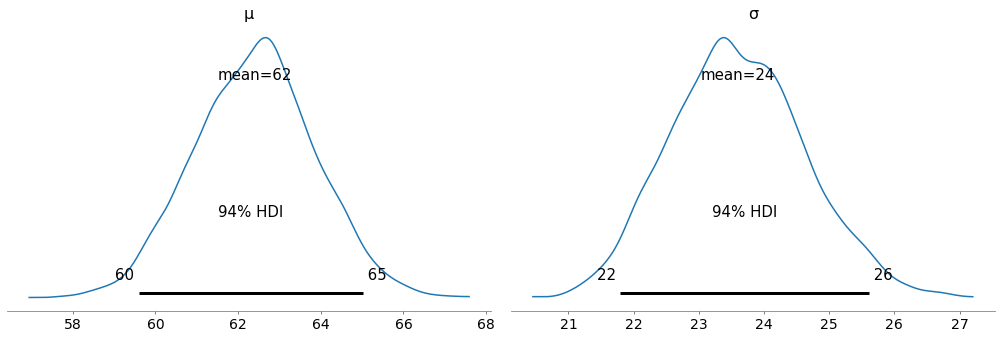

In [11]:
az.plot_posterior(trace_g);

In [14]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.stats.gelman_rubin(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

AttributeError: module 'pymc3.stats' has no attribute 'gelman_rubin'

In [16]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(1000, 258)

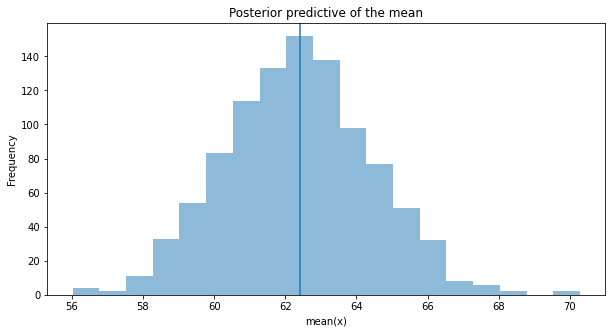

In [20]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [21]:
price = data['price'].values
idx = pd.Categorical(data['fare'], categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

In [22]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)

/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 25 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7172636775534186, but should be close to 0.8. Try to increase the number of tuning steps.


In [23]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],71.434,2.456,66.954,76.178,0.019,0.013,16665.0,16665.0,16870.0,12560.0,1.0
μ[1],60.291,1.686,57.002,63.353,0.013,0.009,17482.0,17482.0,17495.0,14366.0,1.0
μ[2],35.883,2.061,32.107,39.451,0.022,0.015,8900.0,8900.0,12360.0,7669.0,1.0
μ[3],28.991,1.108,26.856,31.000,0.009,0.006,15649.0,15649.0,16113.0,12704.0,1.0
σ[0],18.273,1.714,15.165,21.526,0.014,0.010,15174.0,14803.0,15668.0,13006.0,1.0
σ[1],22.989,1.199,20.780,25.262,0.010,0.007,14512.0,14445.0,14587.0,13223.0,1.0
σ[2],4.986,1.798,2.510,8.118,0.019,0.014,8659.0,7698.0,11568.0,9571.0,1.0
σ[3],4.210,0.899,2.744,5.856,0.008,0.006,13843.0,12731.0,14663.0,12749.0,1.0


To make it clearer, we plot the difference between each fare category without repeating the comparison.

Cohen’s d is an appropriate effect size for the comparison between two means. Cohen’s d introduces the variability of each group by using their standard deviations.

probability of superiority (ps) is defined as the probability that a data point taken at random from one group has a larger value than one taken at random from another group.

IndexError: index 4 is out of bounds for axis 1 with size 4

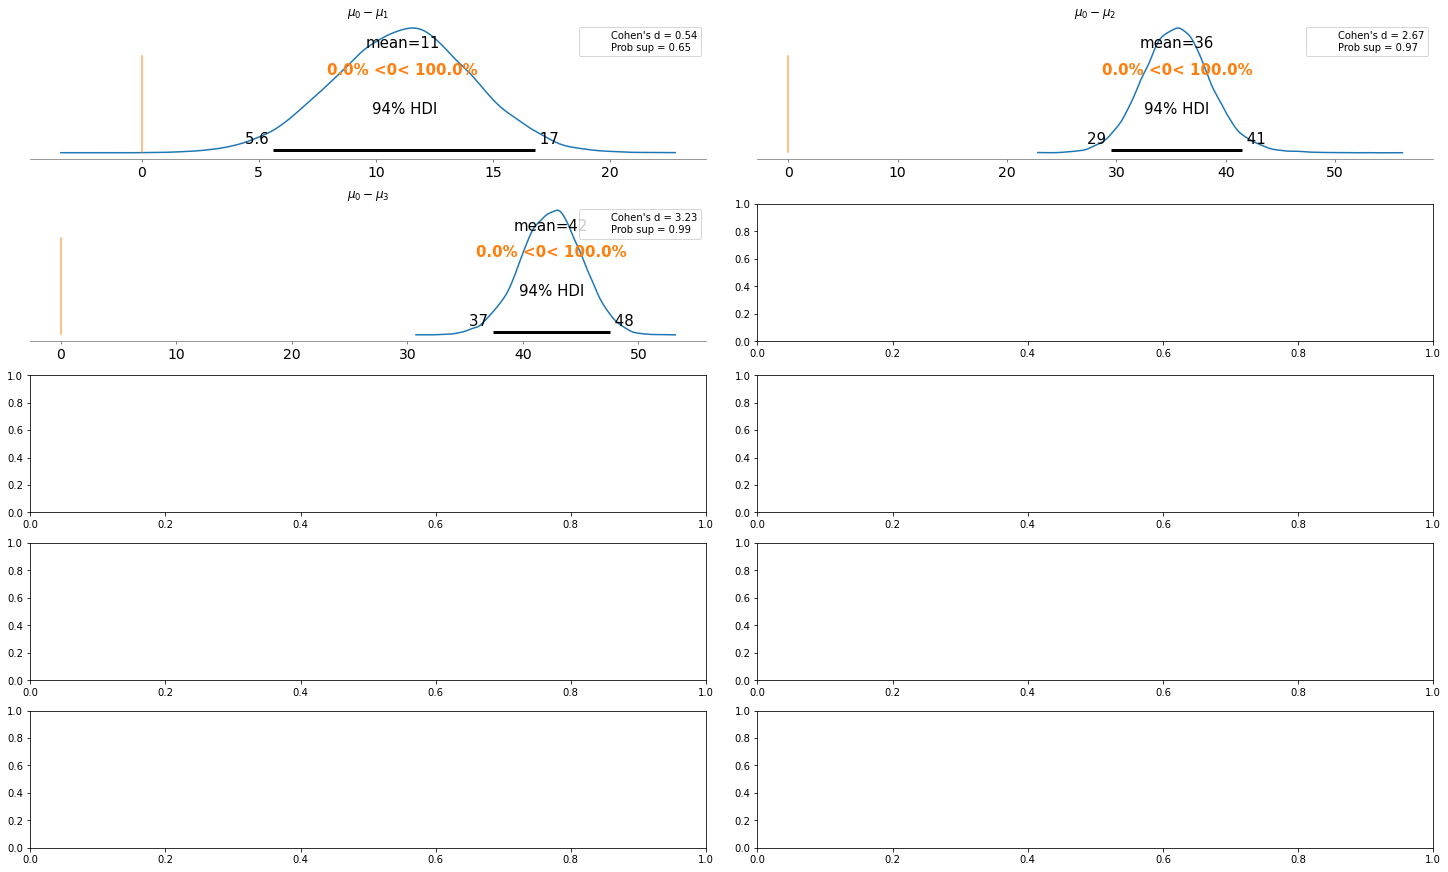

In [27]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

In [28]:
def replace_fare(fare):    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

data['fare_encode'] = data['fare'].apply(lambda x: replace_fare(x))

label_encoder = preprocessing.LabelEncoder() 
data['train_type_encode']= label_encoder.fit_transform(data['train_type'])

train_type_names = data.train_type.unique()
train_type_idx = data.train_type_encode.values

n_train_types = len(data.train_type.unique())

data[['train_type', 'price', 'fare_encode']].head()

,train_type,price,fare_encode
4738,AVE,33.65,3
8722,AVE,85.10,3
13185,AVE,51.15,3
24835,AVE,53.40,3
190,AVE,85.10,3


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 60 seconds.
There were 313 divergences after tuning. Increase `target_accept` or reparameterize.
There were 577 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8119820206074524, but should be close to 0.9. Try to increase the number of tuning steps.
There were 250 divergences after tuning. Increase `target_accept` or reparameterize.
There were 285 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model c

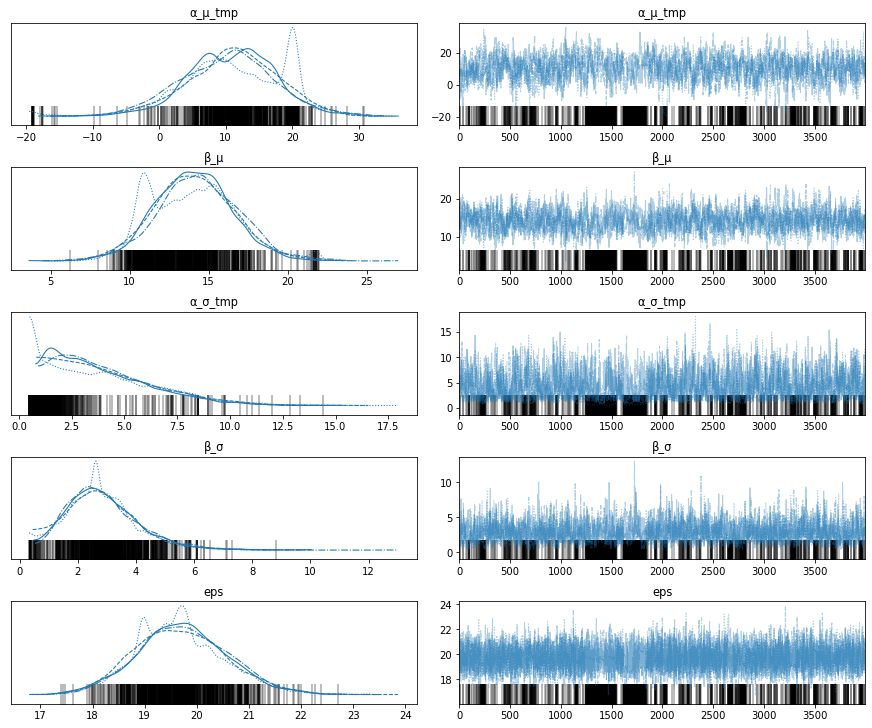

In [31]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*data.fare_encode.values

    # Data likelihood
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=data.price)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(4000, tune=2000, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);

/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


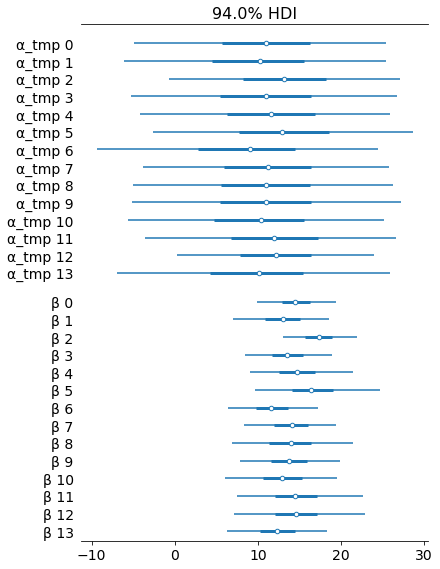

In [32]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True);


In [34]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(data.price.values, ppc['fare_like'])


/Users/paulrice/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


r2        0.292657
r2_std    0.010751
dtype: float64